# 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np

In [2]:
# 이상치 처리 후 member와 sales 데이터를 합친 CSV 파일 읽어오기 
df = pd.read_csv("jeju_merge_sales_rm.csv" , encoding = 'utf-8')
df.head()

,customer_id,birth_date,gender,age,agegroup,customer_type,customer_grade,gaip_date,taltoi_date,member_month,...,purchase_date,purchase_time,supply_date,item_id,item_g_l,item_g_m,item_g_s,purchase_cnt,unit_cost,purchase_amt
0,C118113,1975-08-18,여,45,40대,일반,3Gold,2011-12-06,NaN,97,...,2018-01-10,:0:14:47:04,2018-01-10,P08010117,간식,과자,스낵,1,3000,3000
1,C118113,1975-08-18,여,45,40대,일반,3Gold,2011-12-06,NaN,97,...,2018-01-10,:0:14:47:04,2018-01-10,P09040101,양념/가루,장,간장,1,7900,7900
2,C118113,1975-08-18,여,45,40대,일반,3Gold,2011-12-06,NaN,97,...,2018-01-10,:0:14:47:04,2018-01-10,P09040100,양념/가루,장,간장,1,13600,13600
3,C118113,1975-08-18,여,45,40대,일반,3Gold,2011-12-06,NaN,97,...,2018-10-08,:0:11:59:24,2018-10-08,P09010305,양념/가루,가루,곡식가루,2,3200,6400
4,C118113,1975-08-18,여,45,40대,일반,3Gold,2011-12-06,NaN,97,...,2018-10-08,:0:11:59:24,2018-10-08,P09010301,양념/가루,가루,곡식가루,2,11000,22000


In [3]:
# 문자열로 된 날짜를 Timestamp형식으로 변환
df['purchase_date'] = pd.to_datetime(df['purchase_date']) 

In [4]:
# 사용할 칼럼만 추출 
df = df[['customer_id', 'purchase_id', 'purchase_date', 'purchase_amt']]

In [5]:
df.head()

,customer_id,purchase_id,purchase_date,purchase_amt
0,C118113,C118113_20180110_87,2018-01-10,3000
1,C118113,C118113_20180110_87,2018-01-10,7900
2,C118113,C118113_20180110_87,2018-01-10,13600
3,C118113,C118113_20181008_22,2018-10-08,6400
4,C118113,C118113_20181008_22,2018-10-08,22000


# 데이터 변환

In [6]:
base_date = pd.to_datetime('20191231') # 기준일: 2020-12-31
time_diff = df['purchase_date'] - base_date # 구매일과 기준일의 차이
df['purchase_date'] = abs(time_diff)
df['purchase_date'] = df['purchase_date'].astype('timedelta64[D]') # float형으로 변환 

In [7]:
# Recency
recency_df = pd.DataFrame()
recency_df['Recency'] = df.groupby("customer_id")["purchase_date"].agg("min") # 최종 구매일과 기준일의 차이

In [8]:
df_6m = df[df.purchase_date <= 180] #기준일로부터 6개월 이내의 구매기록이 있는 고객의 데이터만 추출. 

# Monetary
monetary_df = pd.DataFrame() # 구매금액 데이터 초기화
monetary_df['Monetary'] = df_6m.groupby("customer_id")["purchase_amt"].agg("sum") #고객 아이디별 구매금액 합산 

# Frequency
freq = df_6m[['customer_id','purchase_id']].drop_duplicates() # 고객 아이디와 구매아이디만 추출한뒤 중복 제거
frequency_df = freq.groupby('customer_id')['purchase_id'].count().reset_index() ## 아이디로 그룹화 한다음 방문횟수를 구해야 한다. 여기서는 방문횟수를 구매 아이디 개수로 생각했으므로 구매아이디에 count를 적용한다.
frequency_df = frequency_df.rename(columns={'purchase_id':'Frequency'})

In [9]:
# Recency, Frequency, Monetary 데이터를 고객아이디를 기준으로 합침. 
rfm_df_6m = pd.merge(recency_df,frequency_df,how='inner',on='customer_id')
rfm_df_6m = pd.merge(rfm_df_6m,monetary_df,how='inner',on='customer_id')

In [10]:
rfm_df_6m

,customer_id,Recency,Frequency,Monetary
0,C118291,1.0,21,442050
1,C118294,44.0,6,82550
2,C118295,124.0,2,25900
3,C118298,14.0,17,168950
4,C118300,43.0,1,87000
...,...,...,...,...
1971,C704198,5.0,4,49850
1972,C704239,1.0,1,18900
1973,C704271,10.0,5,43800
1974,C704612,11.0,1,10800


In [11]:
rfm_df_6m.describe().round(0)

,Recency,Frequency,Monetary
count,1976.0,1976.0,1976.0
mean,48.0,9.0,167469.0
std,48.0,12.0,277527.0
min,1.0,1.0,1000.0
25%,8.0,2.0,20138.0
50%,29.0,4.0,61850.0
75%,76.0,11.0,190838.0
max,180.0,142.0,2847145.0


# R, F, M  점수 부여

In [12]:
#RFM Class 

def recency_R(x):  #최근성 
    if 0<x<=30: return 6
    elif 30<x<=60: return 5
    elif 60<x<=90: return 4
    elif 90<x<=120: return 3
    elif 120<x<=150: return 2
    elif 150<x<=180: return 1
    else: return 0

def frequency_F(x):  #구매횟수 
    if 0<x<=1: return 0
    elif 1<x<=2: return 1
    elif 2<x<=3: return 2
    elif 3<x<=4: return 3
    elif 4<x<=7: return 4
    elif 7<x<=11: return 5
    else: return 6

def monetary_M(x):  #구매금액 
    if 0<x<=10000: return 0
    elif 10000<x<=20000: return 1
    elif 20000<x<=42000: return 2
    elif 42000<x<=62000: return 3
    elif 62000<x<=140000: return 4
    elif 140000<x<=192000: return 5
    else: return 6

In [13]:
# R, F, M 점수 부여 
rfm_table = pd.DataFrame()
rfm_table["R"] = rfm_df_6m["Recency"].apply(recency_R)
rfm_table["F"] = rfm_df_6m["Frequency"].apply(frequency_F)
rfm_table["M"] = rfm_df_6m["Monetary"].apply(monetary_M)

In [14]:
rfm_total = pd.concat([rfm_df_6m, rfm_table], axis=1)
rfm_total

,customer_id,Recency,Frequency,Monetary,R,F,M
0,C118291,1.0,21,442050,6,6,6
1,C118294,44.0,6,82550,5,4,4
2,C118295,124.0,2,25900,2,1,2
3,C118298,14.0,17,168950,6,6,5
4,C118300,43.0,1,87000,5,0,4
...,...,...,...,...,...,...,...
1971,C704198,5.0,4,49850,6,3,3
1972,C704239,1.0,1,18900,6,0,1
1973,C704271,10.0,5,43800,6,4,3
1974,C704612,11.0,1,10800,6,0,1


# RFM 가중치 설정 및 RFM score 계산

In [15]:
# 가중치 설정
w1 = 0.35  #R에 대한 가중치 
w2 = 0.4  #F에 대한 가중치 
w3 = 0.25  #M에 대한 가중치 

def rfm_scoring(x,y,z):
    return x + y + z

def recency(x):
    return w1*x

def frequency(y):
    return w2*y

def monetary(z):
    return w3*z

w1_x=rfm_total['R'].apply(recency)
w2_y=rfm_total['F'].apply(frequency)
w3_z= rfm_total['M'].apply(monetary)

rfm_score = pd.DataFrame({'RFM': rfm_scoring(w1_x, w2_y, w3_z)})  #RFM score 계산 

In [16]:
rfm_score

,RFM
0,6.00
1,4.35
2,1.60
3,5.75
4,2.75
...,...
1971,4.05
1972,2.35
1973,4.45
1974,2.35


In [17]:
rfm_total = pd.concat([rfm_total, rfm_score], axis=1)
rfm_total

,customer_id,Recency,Frequency,Monetary,R,F,M,RFM
0,C118291,1.0,21,442050,6,6,6,6.00
1,C118294,44.0,6,82550,5,4,4,4.35
2,C118295,124.0,2,25900,2,1,2,1.60
3,C118298,14.0,17,168950,6,6,5,5.75
4,C118300,43.0,1,87000,5,0,4,2.75
...,...,...,...,...,...,...,...,...
1971,C704198,5.0,4,49850,6,3,3,4.05
1972,C704239,1.0,1,18900,6,0,1,2.35
1973,C704271,10.0,5,43800,6,4,3,4.45
1974,C704612,11.0,1,10800,6,0,1,2.35


In [18]:
rfm_total['RFM'].describe()

count    1976.000000
mean        3.694762
std         1.791026
min         0.350000
25%         2.100000
50%         3.800000
75%         5.500000
max         6.000000
Name: RFM, dtype: float64

# 회원 등급 세분화

In [19]:
silver = rfm_total[rfm_total.RFM < 2]  

In [20]:
silver.head()

,customer_id,Recency,Frequency,Monetary,R,F,M,RFM
2,C118295,124.0,2,25900,2,1,2,1.60
7,C118530,78.0,1,3900,4,0,0,1.40
10,C119415,140.0,1,28900,2,0,2,1.20
20,C124489,73.0,1,19700,4,0,1,1.65
22,C125135,171.0,2,8650,1,1,0,0.75


In [21]:
gold = rfm_total.loc[(rfm_total.RFM >= 2) & (rfm_total.RFM < 5)]

In [22]:
gold.head()

,customer_id,Recency,Frequency,Monetary,R,F,M,RFM
1,C118294,44.0,6,82550,5,4,4,4.35
4,C118300,43.0,1,87000,5,0,4,2.75
5,C118476,31.0,6,169400,5,4,5,4.60
6,C118477,89.0,6,172450,4,4,5,4.25
8,C118590,35.0,9,91050,5,5,4,4.75


In [23]:
platinum = rfm_total.loc[(rfm_total.RFM >= 5) & (rfm_total.RFM < 6)]

In [24]:
platinum.head()

,customer_id,Recency,Frequency,Monetary,R,F,M,RFM
3,C118298,14.0,17,168950,6,6,5,5.75
9,C119301,16.0,13,101720,6,6,4,5.50
13,C121157,16.0,8,127800,6,5,4,5.10
29,C127803,8.0,5,259700,6,4,6,5.20
32,C128606,31.0,14,133160,5,6,4,5.15


In [25]:
royal = rfm_total[rfm_total.RFM >= 6]

In [26]:
royal.head()

,customer_id,Recency,Frequency,Monetary,R,F,M,RFM
0,C118291,1.0,21,442050,6,6,6,6.0
15,C121449,2.0,19,983500,6,6,6,6.0
16,C121819,1.0,14,273200,6,6,6,6.0
17,C122517,1.0,28,394060,6,6,6,6.0
19,C123755,5.0,14,480000,6,6,6,6.0


In [27]:
# 새로운 고객등급 세분화 
def grade(x):
    if x<2: return 'new_4Silver'
    elif 2<=x<5: return 'new_3Gold'
    elif 5<=x<6: return 'new_2Platinum'
    else: return 'new_1Royal'


rfm_grade = pd.DataFrame()
rfm_grade["new_grade"] = rfm_total["RFM"].apply(grade)

In [28]:
rfm_grade.head()

,new_grade
0,new_1Royal
1,new_3Gold
2,new_4Silver
3,new_2Platinum
4,new_3Gold


In [29]:
rfm_total_grade = pd.concat([rfm_total, rfm_grade], axis=1)
rfm_total_grade.head()

,customer_id,Recency,Frequency,Monetary,R,F,M,RFM,new_grade
0,C118291,1.0,21,442050,6,6,6,6.00,new_1Royal
1,C118294,44.0,6,82550,5,4,4,4.35,new_3Gold
2,C118295,124.0,2,25900,2,1,2,1.60,new_4Silver
3,C118298,14.0,17,168950,6,6,5,5.75,new_2Platinum
4,C118300,43.0,1,87000,5,0,4,2.75,new_3Gold


In [30]:
# 기존 회원 등급 불러오기 
mem_df = pd.read_csv("jeju_member_전처리.csv" )

In [31]:
mem_df.drop('Unnamed: 0', axis=1)

,customer_id,birth_date,gender,age,agegroup,customer_type,customer_grade,gaip_date,taltoi_date,member_month,gaip_path,flag_member,flag_rcv_sms,flag_rcv_email,flag_rcv_post,sigun,dong,address
0,C102666,1976-11-08,남,44,40대,일반,3Gold,2014-10-07,NaN,63,매장,Y,Y,Y,Y,제주시,연동,제주시 연동
1,C118113,1975-08-18,여,45,40대,일반,3Gold,2011-12-06,NaN,97,기타,Y,Y,Y,Y,제주시,아라2동,제주시 아라2동
2,C118133,1981-03-20,남,39,30대,일반,4Silver,2011-12-07,2014-04-02,28,매장,N,Y,Y,N,서귀포시,성산읍,서귀포시 성산읍
3,C118278,1979-06-22,여,41,40대,일반,3Gold,2011-12-11,NaN,97,인터넷,Y,Y,Y,Y,제주시,애월읍,제주시 애월읍
4,C118280,1959-08-28,남,61,60대,일반,3Gold,2011-12-11,2016-05-02,53,기타,N,N,N,N,서귀포시,성산읍,서귀포시 성산읍
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6008,C705804,1962-08-13,여,58,50대,일반,2Platinum,2019-12-09,NaN,1,인터넷,Y,Y,Y,Y,서귀포시,동홍동,서귀포시 동홍동
6009,C706457,1995-10-12,여,25,20대,일반,4Silver,2019-12-11,NaN,1,인터넷,Y,Y,Y,N,제주시,화북일동,제주시 화북일동
6010,C707942,1986-09-20,여,34,30대,일반,4Silver,2019-12-19,NaN,1,인터넷,Y,Y,N,Y,제주시,조천읍,제주시 조천읍
6011,C707954,1984-04-20,여,36,30대,일반,3Gold,2019-12-19,NaN,1,인터넷,Y,N,N,N,제주시,도남동,제주시 도남동


In [32]:
orig_grade = pd.DataFrame()
orig_grade = mem_df[['customer_id', 'customer_grade']]

In [33]:
rfm_total_grade = pd.merge(rfm_total_grade, orig_grade, how='inner', on= 'customer_id')
rfm_total_grade.head()

,customer_id,Recency,Frequency,Monetary,R,F,M,RFM,new_grade,customer_grade
0,C118291,1.0,21,442050,6,6,6,6.00,new_1Royal,1Royal
1,C118294,44.0,6,82550,5,4,4,4.35,new_3Gold,2Platinum
2,C118295,124.0,2,25900,2,1,2,1.60,new_4Silver,3Gold
3,C118298,14.0,17,168950,6,6,5,5.75,new_2Platinum,2Platinum
4,C118300,43.0,1,87000,5,0,4,2.75,new_3Gold,1Royal


In [34]:
# csv 파일로 저장하기 
rfm_total_grade.to_csv('rfm_6m.csv')

---> 기준일(2019-12-31)로부터 6개월치 데이터만 가지고 등급 재조정한 결과 

In [35]:
# 기존 등급과 새로 조정한 등급에 대한 교차도표 

old_new = pd.crosstab(rfm_total_grade.customer_grade, rfm_total_grade.new_grade, margins=True)

In [36]:
old_new

new_grade,new_1Royal,new_2Platinum,new_3Gold,new_4Silver,All
customer_grade,,,,,
1Royal,68,7,7,2,84
2Platinum,202,137,266,51,656
3Gold,95,126,575,288,1084
4Silver,2,0,60,90,152
All,367,270,908,431,1976


# Contingency Plot (Mosaic Plot)

In [37]:
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.pyplot as plt

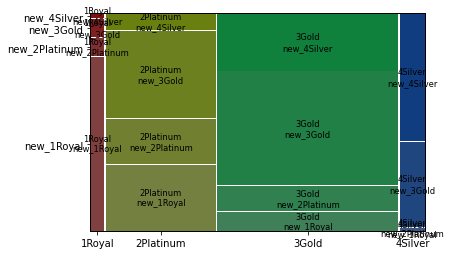

In [38]:
mosaic(rfm_total_grade.sort_values('new_grade'), ['customer_grade', 'new_grade'])

plt.rcParams['figure.figsize'] = [8,5]
plt.show()

# 고객 1회 방문당 구매금액

신규고객 n명 유치시 매출액이 얼마나 향상되는지 예측 가능

In [39]:
# 2년치 데이터

df_2y = pd.DataFrame() # 구매금액 데이터 초기화
df_2y['sum_purchase_amt'] = df.groupby("customer_id")["purchase_amt"].agg("sum")

In [40]:
freq_2y = df[['customer_id','purchase_id']].drop_duplicates() # 고객 아이디와 구매 아이디만 추출한뒤 중복 제거
frequency_2y_df = freq_2y.groupby('customer_id')['purchase_id'].count().reset_index() ## 아이디로 그룹화 한다음 방문횟수를 구해야 한다. 여기서는 방문횟수를 구매 아이디 개수로 생각했으므로 구매 아이디에 count를 적용한다.
frequency_2y_df = frequency_2y_df.rename(columns={'purchase_id':'Frequency'})

frequency_2y_df

,customer_id,Frequency
0,C118113,3
1,C118291,41
2,C118294,15
3,C118295,7
4,C118298,70
...,...,...
2749,C704198,4
2750,C704239,1
2751,C704271,5
2752,C704612,1


In [41]:
freq_amt_2y = pd.merge(frequency_2y_df, df_2y,how='inner',on='customer_id')

In [42]:
freq_amt_2y.head()

,customer_id,Frequency,sum_purchase_amt
0,C118113,3,99500
1,C118291,41,1062850
2,C118294,15,165000
3,C118295,7,107600
4,C118298,70,526300


In [43]:
# 2년치 데이터 기준 :  고객 1회 방문당 평균 구매금액

mean_amt_2y = freq_amt_2y['sum_purchase_amt'].sum() / freq_amt_2y['Frequency'].sum() 
mean_amt_2y

22494.24859563356

In [44]:
# 2018년 데이터 

df_2018 = df.loc[(df.purchase_date >= 360) & (df.purchase_date < 720)]
df_18 = pd.DataFrame()
df_18['sum_purchase_amt'] = df_2018.groupby("customer_id")["purchase_amt"].agg("sum")

In [45]:
df_18.head()

,sum_purchase_amt
customer_id,
C118113,75000
C118291,541300
C118294,45150
C118295,72300
C118298,219300


In [46]:
freq_18 = df_2018[['customer_id','purchase_id']].drop_duplicates() # 고객 아이디와 구매 아이디만 추출한뒤 중복 제거
frequency_18_df = freq_18.groupby('customer_id')['purchase_id'].count().reset_index() ## 아이디로 그룹화 한다음 방문횟수를 구해야 한다. 여기서는 방문횟수를 구매아이디 개수로 생각했으므로 구매아이디에 count를 적용한다.
frequency_18_df = frequency_18_df.rename(columns={'purchase_id':'Frequency'})

frequency_18_df.head()

,customer_id,Frequency
0,C118113,2
1,C118291,17
2,C118294,4
3,C118295,4
4,C118298,31


In [47]:
freq_amt_18 = pd.merge(frequency_18_df, df_18,how='inner',on='customer_id')

In [48]:
# 2018년 데이터 기준 :  고객 1회 방문당 평균 구매금액

mean_amt_18 = freq_amt_18['sum_purchase_amt'].sum() / freq_amt_18['Frequency'].sum() 
mean_amt_18

25278.944060084767

In [49]:
# 2019년 데이터 

df_2019 = df[df.purchase_date <= 360]
df_19 = pd.DataFrame()
df_19['sum_purchase_amt'] = df_2019.groupby("customer_id")["purchase_amt"].agg("sum")

In [50]:
freq_19 = df_2019[['customer_id','purchase_id']].drop_duplicates() # 고객 아이디와 구매아이디만 추출한뒤 중복 제거
frequency_19_df = freq_19.groupby('customer_id')['purchase_id'].count().reset_index() ## 아이디로 그룹화 한다음 방문횟수를 구해야 한다. 여기서는 방문횟수를 구매아이디 개수로 생각했으므로 구매아이디에 count를 적용한다.
frequency_19_df = frequency_19_df.rename(columns={'purchase_id':'Frequency'})

frequency_19_df.head()

,customer_id,Frequency
0,C118291,24
1,C118294,11
2,C118295,2
3,C118298,39
4,C118299,1


In [51]:
freq_amt_19 = pd.merge(frequency_19_df, df_19,how='inner',on='customer_id')

# 2019년 데이터 기준 :  고객 1회 방문당 평균 구매금액

mean_amt_19 = freq_amt_19['sum_purchase_amt'].sum() / freq_amt_19['Frequency'].sum() 
mean_amt_19

19707.81427100993

In [52]:
# 최근 6개월치 데이터 기준

df_6month = pd.DataFrame()
df_6month['sum_purchase_amt'] = df_6m.groupby("customer_id")["purchase_amt"].agg("sum")

In [53]:
freq_6m = df_6m[['customer_id','purchase_id']].drop_duplicates() # 고객 아이디와 구매아이디만 추출한뒤 중복 제거
frequency_6m_df = freq_6m.groupby('customer_id')['purchase_id'].count().reset_index() ## 아이디로 그룹화 한다음 방문횟수를 구해야 한다. 여기서는 방문횟수를 구매아이디 개수로 생각했으므로 구매아이디에 count를 적용한다.
frequency_6m_df = frequency_6m_df.rename(columns={'purchase_id':'Frequency'})

frequency_6m_df.head()

,customer_id,Frequency
0,C118291,21
1,C118294,6
2,C118295,2
3,C118298,17
4,C118300,1


In [54]:
freq_amt_6m = pd.merge(frequency_6m_df, df_6month,how='inner',on='customer_id')

# 최근 6개월치 데이터 기준: 고객 1회 방문당 평균 구매금액 

mean_amt_6m = freq_amt_6m['sum_purchase_amt'].sum() / freq_amt_6m['Frequency'].sum() 
mean_amt_6m

19232.76537254446

In [55]:
print("<고객 1회 방문당 평균 구매금액>")
print("2018-2019년: %.1f(원) \n2018년: %.1f(원) \n2019년: %.1f(원) \n6개월(2019년 7-12월): %.1f(원)" %(mean_amt_2y,mean_amt_18,mean_amt_19,mean_amt_6m))

<고객 1회 방문당 평균 구매금액>
2018-2019년: 22494.2(원) 
2018년: 25278.9(원) 
2019년: 19707.8(원) 
6개월(2019년 7-12월): 19232.8(원)
